____
__Universidad de San Andrés__<br/>
__Machine Learning__<br/>
__Detección de ballenas__<br/>
__Martin Bianchi y Federico Gutman__
____

### Importamos las librerías necesarias

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from IPython.display import Audio, display
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

### NOTAS
- ver repo para preprocesar espectrogrma
    - ver de reducir el y-lim del spectrograma -> averiguar bien entre que frecuencias se mueven los cantos de ballena
- cambiar noise a no right whale
- cambiar el idioma a español


### Definimos algunas variables globales

In [2]:
SEED = 3            # semilla para reproductibilidad
SR = 2000           # sampling rate
N_FFT = 256         # tamaño de la ventana
HOP_LENGTH = 64     # salto entre frames
N_MELS = 50         # frequency bins (resolución)
MAX_FREQ = 600      # máxima frecuencia para los espectrogramas --ponerlo en 500--

### Cargamos los datos y los visualizamos

In [3]:
def load_data(train_path:str, test_path:str, labels_path:str, sampling_rate=SR):
    test_files = [f for f in os.listdir(test_path) if f.endswith('.aiff')]
    labels_df = pd.read_csv(labels_path)

    audio_df = labels_df.copy()
    audio_df['filepath'] = audio_df['clip_name'].apply(lambda x: os.path.join(train_path, x))
    audio_df['audio'] = audio_df['filepath'].apply(lambda path: librosa.load(path, sr=sampling_rate)[0])

    return audio_df, labels_df, test_files

def display_random_samples(dataset:pd.DataFrame, sampling_rate=SR):
    np.random.seed(SEED)

    # SAMPLES
    whale_sample = dataset[dataset['label'] == 1].sample(5)['audio']
    noise_sample = dataset[dataset['label'] == 0].sample(5)['audio']

    # AUDIO
    print('right whale call random audio sample')
    display(Audio(np.array(whale_sample.iloc[0]), rate=sampling_rate*2))
    print('\nno Whale random audio sample')
    display(Audio(np.array(noise_sample.iloc[0]), rate=sampling_rate*2))

    # SOUND-WAVE
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))

    for i in range(5):
        axes[0, i].plot(np.array(whale_sample.iloc[i]))
        axes[0, i].set_title('Whale')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        axes[1, i].plot(np.array(noise_sample.iloc[i]), color='#FF6961')
        axes[1, i].set_title('No Whale')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

    plt.tight_layout()
    plt.show()

    # MULTIPLE SPECTROGRAMS
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(5):
        whale_sample_spectrogram = get_melspectrogram(whale_sample.iloc[i])
        img0 = librosa.display.specshow(whale_sample_spectrogram, sr=sampling_rate, hop_length=64, ax=axes[0, i],x_axis='time', y_axis='hz', cmap='magma')
        axes[0, i].set_title('Whale')
        axes[0, i].set_ylim([0, MAX_FREQ])
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        noise_sample_spectrogram = get_melspectrogram(noise_sample.iloc[i])
        img1 = librosa.display.specshow(noise_sample_spectrogram, sr=sampling_rate, hop_length=64, ax=axes[1, i], x_axis='time', y_axis='hz', cmap='magma')
        axes[1, i].set_title('No Whale')
        axes[1, i].set_ylim([0, MAX_FREQ])
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

    plt.tight_layout()
    plt.show()

    # TWO SPECTROGRAMS
    whale_sample2 = dataset[dataset['label'] == 1].sample(1, random_state=SEED+1)['audio']
    noise_sample2 = dataset[dataset['label'] == 0].sample(1, random_state=SEED+1)['audio']
    
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    whale_sample2_spectrogram = get_melspectrogram(whale_sample2.iloc[0])
    img0 = librosa.display.specshow(whale_sample2_spectrogram, sr=sampling_rate, hop_length=64, ax=axes[0], x_axis='time', y_axis='hz', cmap='magma')
    axes[0].set_title('Whale')
    axes[0].set_ylim([0, MAX_FREQ])
    fig.colorbar(img0, ax=axes[0], format="%+2.0f dB")

    noise_sample2_spectrogram = get_melspectrogram(noise_sample2.iloc[0])
    img1 = librosa.display.specshow(noise_sample2_spectrogram, sr=sampling_rate, hop_length=64, ax=axes[1], x_axis='time', y_axis='hz', cmap='magma')
    axes[1].set_title('No Whale')
    axes[1].set_ylim([0, MAX_FREQ])
    fig.colorbar(img1, ax=axes[1], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

def normalize(dataset:pd.DataFrame, column:str):
    dataset[column] = dataset[column].apply(lambda x: x / np.max(np.abs(x)))

def get_signal_energy(dataset:pd.DataFrame, column:str):
    energy = []
    df = dataset.copy()
    for x in df[column]:
        energy.append(np.sum(np.square(x)))
    df['energy'] = energy

    return df

def get_melspectrogram(sample:pd.DataFrame, sampling_rate=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_spectrogram = librosa.feature.melspectrogram(y=np.array(sample), sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=MAX_FREQ)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram

def get_all_mel_spectrograms(audio_df, sampling_rate=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_specs = []
    for audio in audio_df['audio']:
        mel = get_melspectrogram(audio, sampling_rate, n_fft, hop_length, n_mels)
        mel_specs.append(mel.flatten())
    return np.array(mel_specs)

def show_class_balance(dataset:pd.DataFrame):
    plt.figure(figsize=(5, 4))
    ax = sns.countplot(
        x='label',
        data=dataset,
        palette={0: '#FF6961', 1: plt.rcParams['axes.prop_cycle'].by_key()['color'][0]},
        hue='label',
        legend=False
    )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Noise', 'Whale'])
    ax.legend(['Noise', 'Whale'], title='Class')
    plt.show()

def extract_time_acoustic_features(dataset:pd.DataFrame):
    new_features = []
    for audio in dataset['audio']:
        audio_np = np.array(audio)
        acoustic_features = {
            'rms_energy': np.mean(librosa.feature.rms(y=audio_np)),
            'zcr': np.mean(librosa.feature.zero_crossing_rate(y=audio_np)),
        }
        new_features.append(acoustic_features)
    features_df = pd.DataFrame(new_features)
    return features_df

def extract_frequency_acoustic_features(dataset:pd.DataFrame):
    new_features = []
    for audio in dataset['audio']:
        audio_np = np.array(audio)
        acoustic_features = {
            'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=audio_np)),
            'spectral_bandwidth': np.mean(librosa.feature.spectral_bandwidth(y=audio_np)),
            'spectral_rolloff': np.mean(librosa.feature.spectral_rolloff(y=audio_np)),
            'spectral_flatness': np.mean(librosa.feature.spectral_flatness(y=audio_np))
        }
        new_features.append(acoustic_features)
    features_df = pd.DataFrame(new_features)
    return features_df

def extract_acoustic_features(dataset:pd.DataFrame):
    time_features = extract_time_acoustic_features(dataset)
    frequency_features = extract_frequency_acoustic_features(dataset)

    new_df = pd.concat([dataset.reset_index(drop=True), time_features], axis=1)
    new_df = pd.concat([new_df.reset_index(drop=True), frequency_features], axis=1)
    
    return new_df

def display_features_boxplots(audio_features_df:pd.DataFrame):
    time_features = ['rms_energy', 'zcr']
    freq_features = ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'spectral_flatness']

    # TIME
    fig, axes = plt.subplots(1, len(time_features), figsize=(5 * len(time_features), 5))
    if len(time_features) == 1:
        axes = [axes]
    for i, feature in enumerate(time_features):
        sns.boxplot(x='label', y=feature, data=audio_features_df, ax=axes[i], showfliers=False)
        axes[i].set_title(f'{feature} by Class')
        axes[i].set_xlabel('Class')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Noise', 'Whale'])

    plt.suptitle('Time Domain Features by Class')
    plt.tight_layout()
    plt.show()

    # FREQUENCY
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    for i, feature in enumerate(freq_features):
        sns.boxplot(x='label', y=feature, data=audio_features_df, ax=axes[i], showfliers=False)
        axes[i].set_title(f'{feature} by Class')
        axes[i].set_xlabel('Class')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Noise', 'Whale'])

    plt.suptitle('Frequency Domain Features by Class')
    plt.tight_layout()
    plt.show()

def plot_pca(dataset:pd.DataFrame, pca_arr):
    plt.figure(figsize=(8,6))
    scatter = sns.scatterplot(
        x=pca_arr[:,0], 
        y=pca_arr[:,1], 
        hue=dataset['label'], 
        palette={0: '#FF6961', 1: '#1f77b4'}
    )
    plt.title('PCA of Mel Spectrograms')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    # Fix legend labels and colors
    handles, _ = scatter.get_legend_handles_labels()
    scatter.legend(handles=handles, title='Class', labels=['Noise', 'Whale'])
    plt.show()

def plot_average_spectrograms(audio_df:pd.DataFrame):
    whale_spectrograms = []
    noise_spectrograms = []
    for audio, label in zip(audio_df['audio'], audio_df['label']):
        spectrogram = get_melspectrogram(audio)
        if label == 1:
            whale_spectrograms.append(spectrogram)
        else: 
            noise_spectrograms.append(spectrogram)
    
    whale_spectrograms = np.array(whale_spectrograms)
    noise_spectrograms = np.array(noise_spectrograms)

    whale_average_spectrogram = whale_spectrograms.mean(axis=0)
    noise_average_spectrogram = noise_spectrograms.mean(axis=0)
    average_differences_spectrogram = whale_average_spectrogram - noise_average_spectrogram

    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    img0 = librosa.display.specshow(whale_average_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[0], x_axis='time', y_axis='mel', cmap='magma')
    axes[0].set_title('Whale Call Average Spectrogram')
    axes[0].set_ylim([0, 500])
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    fig.colorbar(img0, ax=axes[0], format="%+2.0f dB")

    img1 = librosa.display.specshow(noise_average_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[1], x_axis='time', y_axis='mel', cmap='magma')
    axes[1].set_title('Noise Average Spectrogram')
    axes[1].set_ylim([0, 500])
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    fig.colorbar(img1, ax=axes[1], format="%+2.0f dB")

    img2 = librosa.display.specshow(average_differences_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[2], x_axis='time', y_axis='mel', cmap='magma')
    axes[2].set_title('Average Differences Spectrogram')
    axes[2].set_ylim([0, 500])
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    fig.colorbar(img2, ax=axes[2], format="%+2.0f dB")

    # 3 subplots -> average spectrogram whale, noise, resto y consigo diferencias
    plt.tight_layout()
    plt.show()


In [4]:
train_dir = 'data/whale-detection-challenge/data/train'
test_dir = 'data/whale-detection-challenge/data/test'
labels_dir = 'data/whale-detection-challenge/data/train.csv'

audio_df, labels_df, test_files = load_data(train_dir, test_dir, labels_dir)

right whale call random audio sample



no Whale random audio sample


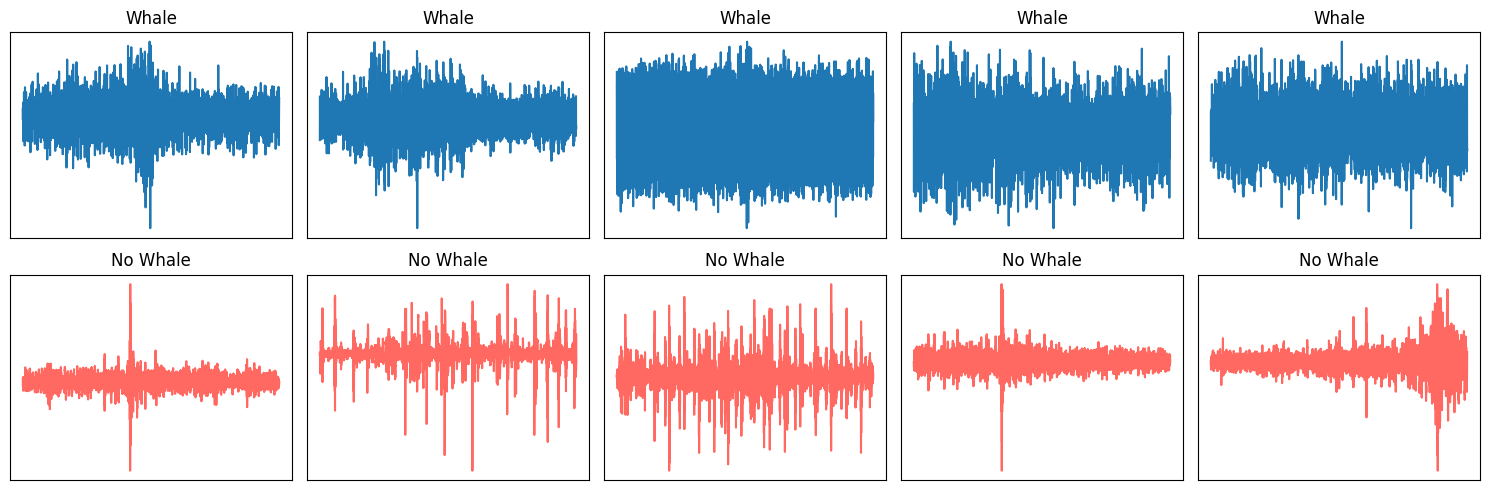

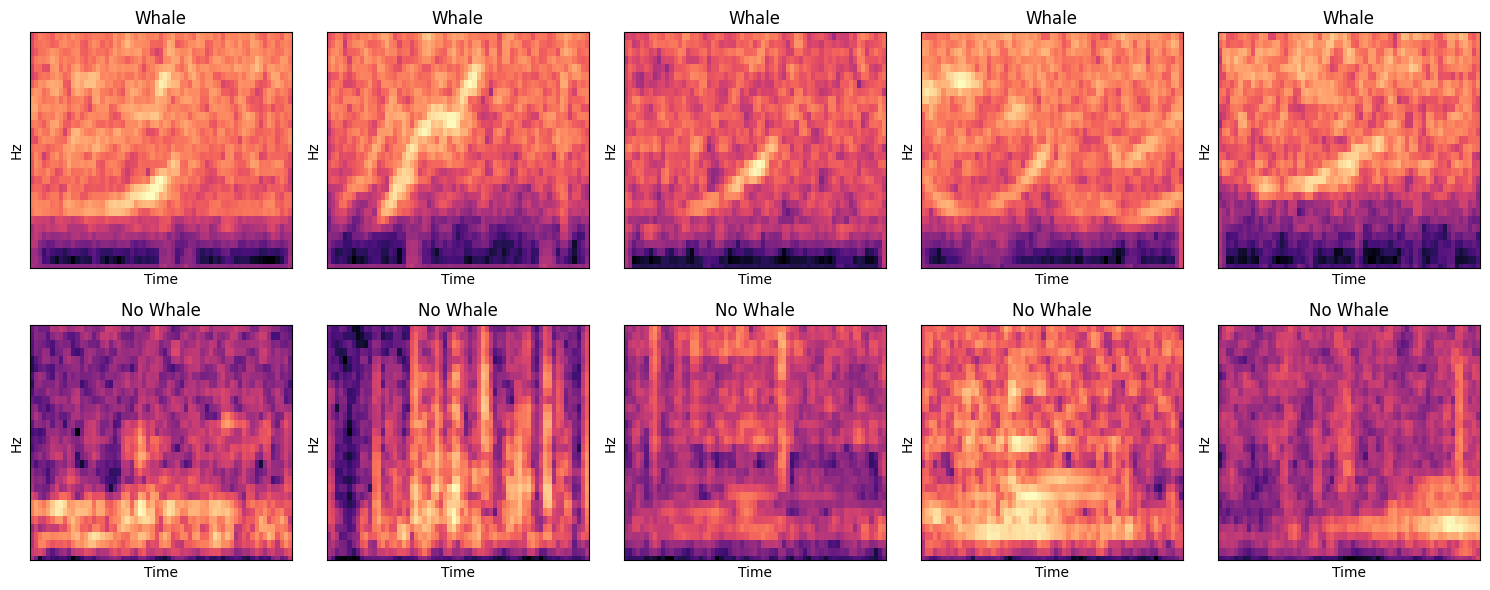

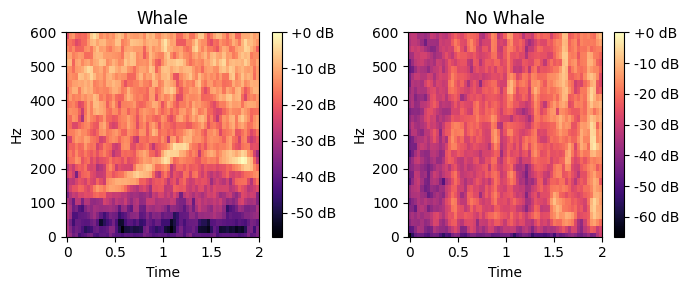

In [5]:
normalize(audio_df, 'audio')
display_random_samples(audio_df)

### Hacemos un análisis exploratorio de los datos

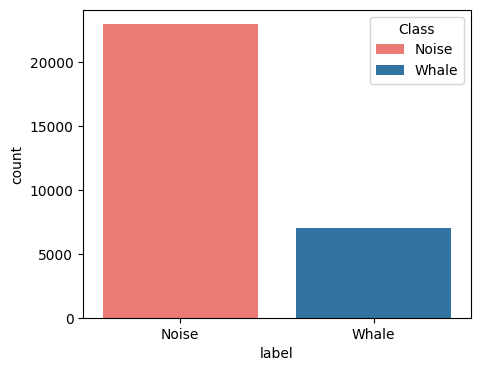

In [6]:
show_class_balance(audio_df)

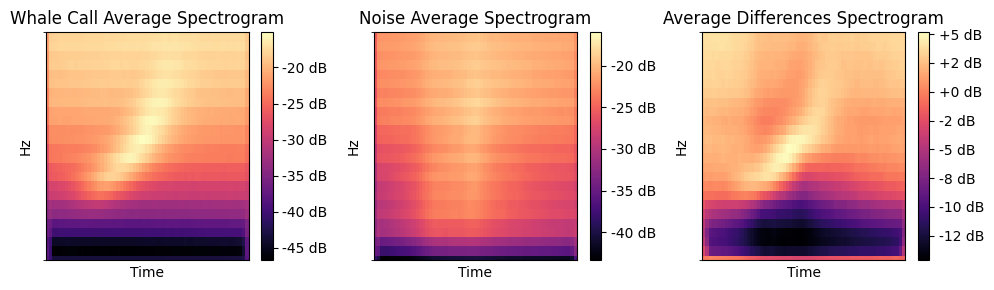

In [7]:
plot_average_spectrograms(audio_df)

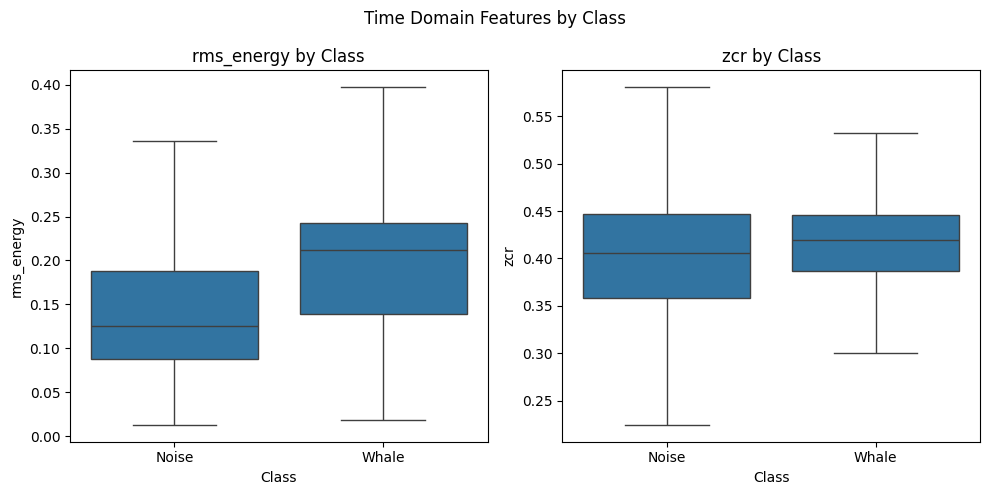

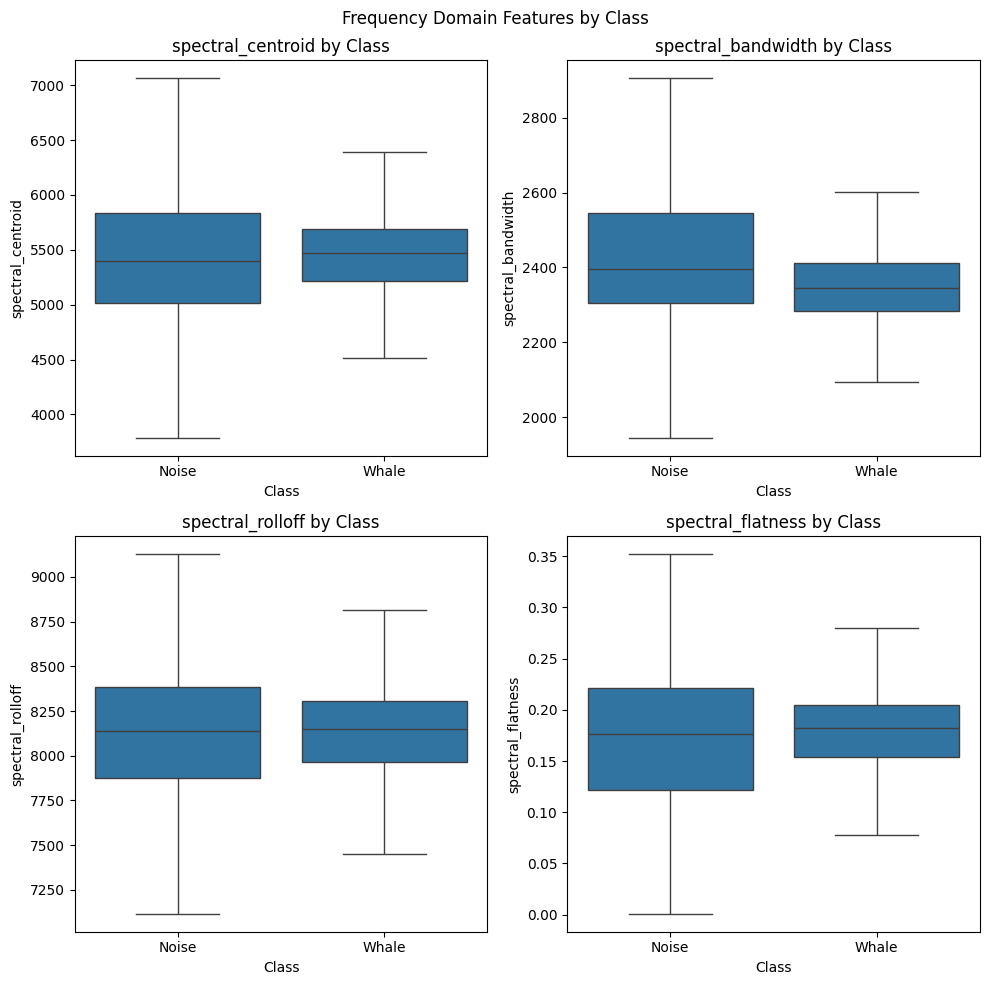

In [8]:
audio_features_df = extract_acoustic_features(audio_df)
display_features_boxplots(audio_features_df)

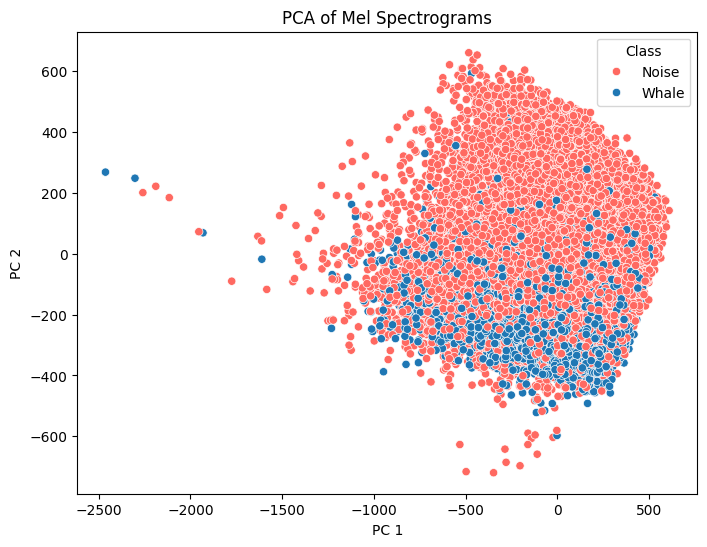

In [9]:
# PCA
flattened_mel_spectrogram = get_all_mel_spectrograms(audio_df)
pca = PCA(n_components=2)
spec_pca = pca.fit_transform(flattened_mel_spectrogram)

plot_pca(audio_df, spec_pca)

### import palazzo as plz

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np


### Busqueda de preproc
Vemos un poco q onda antes, probamos weight y max_freq

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.model(x)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_class_weights(y):
    weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    return torch.tensor(weights, dtype=torch.float32)

for mf in [500, 600, 1000]:
    print(f"\n====== max_freq = {mf} Hz ======")
    MAX_FREQ = mf
    X = get_all_mel_spectrograms(audio_train_df)
    y = audio_train_df['label'].values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128)

    for weighted in [False, True]:
        print(f"\n--- Weighted = {weighted} ---")
        
        # MLP con early stopping
        mlp = MLP(X_train.shape[1]).to(device)
        if weighted:
            weights = get_class_weights(y_train).to(device)
            criterion = nn.CrossEntropyLoss(weight=weights)
        else:
            criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(mlp.parameters(), lr=1e-3)

        best_auc = 0
        patience = 3
        counter = 0

        for epoch in range(20):
            mlp.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(mlp(xb), yb)
                loss.backward()
                optimizer.step()

            mlp.eval()
            all_probs, all_targets = [], []
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(device)
                    probs = torch.softmax(mlp(xb), dim=1)[:, 1].cpu().numpy()
                    all_probs.extend(probs)
                    all_targets.extend(yb.numpy())
            auc = roc_auc_score(all_targets, all_probs)
            print(f"Epoch {epoch+1} - AUC: {auc:.4f}")

            if auc > best_auc:
                best_auc = auc
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping")
                    break

        print(f"AUC MLP final: {best_auc:.4f}")


====== max_freq = 500 Hz ======

--- Weighted = False ---
Epoch 1 - AUC: 0.9051
Epoch 2 - AUC: 0.9195
Epoch 3 - AUC: 0.9262
Epoch 4 - AUC: 0.9302
Epoch 5 - AUC: 0.9312
Epoch 6 - AUC: 0.9355
Epoch 7 - AUC: 0.9355
Epoch 8 - AUC: 0.9330
Epoch 9 - AUC: 0.9389
Epoch 10 - AUC: 0.9409
Epoch 11 - AUC: 0.9395
Epoch 12 - AUC: 0.9424
Epoch 13 - AUC: 0.9444
Epoch 14 - AUC: 0.9390
Epoch 15 - AUC: 0.9444
Epoch 16 - AUC: 0.9417
Epoch 17 - AUC: 0.9447
Epoch 18 - AUC: 0.9386
Epoch 19 - AUC: 0.9457
Epoch 20 - AUC: 0.9408
AUC MLP final: 0.9457

--- Weighted = True ---
Epoch 1 - AUC: 0.9148
Epoch 2 - AUC: 0.9239
Epoch 3 - AUC: 0.9221
Epoch 4 - AUC: 0.9282
Epoch 5 - AUC: 0.9344
Epoch 6 - AUC: 0.9332
Epoch 7 - AUC: 0.9335
Epoch 8 - AUC: 0.9379
Epoch 9 - AUC: 0.9391
Epoch 10 - AUC: 0.9391
Epoch 11 - AUC: 0.9433
Epoch 12 - AUC: 0.9423
Epoch 13 - AUC: 0.9434
Epoch 14 - AUC: 0.9435
Epoch 15 - AUC: 0.9418
Epoch 16 - AUC: 0.9379
Epoch 17 - AUC: 0.9419
Early stopping
AUC MLP final: 0.9435

====== max_freq = 600 H

### Ahora q tenemos preprocesamos
weight y maxfreq no cambio casi nada, habria q entender pq 

In [ ]:
# --------------------------
# Preprocesamiento
# --------------------------
# SEPARAMOS EN TRAIN Y TEST
audio_train_df = audio_df[audio_df['clip_name'].str.contains('train')]
X = get_all_mel_spectrograms(audio_train_df)
y = audio_train_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

### Entrenamos 3 clasif


In [ ]:
MAX_FREQ = 600

# --------------------------
# MLP (PyTorch)
# --------------------------
mlp_torch = MLP(X_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_torch.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_torch.parameters(), lr=1e-3)

epochs = 20
for epoch in range(epochs):
    mlp_torch.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = mlp_torch(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    mlp_torch.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = mlp_torch(xb)
            _, predicted = torch.max(outputs, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()
    val_acc = correct / total
    print(f"Validation Accuracy (MLP): {val_acc:.4f}")

# --------------------------
# Random Forest
# --------------------------
def train_random_forest(X_train, y_train, X_val, y_val):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"Validation Accuracy (Random Forest): {acc:.4f}")
    return rf

# --------------------------
# Gradient Boosting
# --------------------------
def train_gradient_boosting(X_train, y_train, X_val, y_val):
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    gb.fit(X_train, y_train)
    preds = gb.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"Validation Accuracy (Gradient Boosting): {acc:.4f}")
    return gb

# --------------------------
# Ejecutar modelos sklearn
# --------------------------
# Convertimos a numpy si venís usando tensores
X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy()
X_val_np = X_val_tensor.numpy()
y_val_np = y_val_tensor.numpy()

rf_model = train_random_forest(X_train_np, y_train_np, X_val_np, y_val_np)
gb_model = train_gradient_boosting(X_train_np, y_train_np, X_val_np, y_val_np)


Epoch 1/20 - Loss: 0.4686
Validation Accuracy (MLP): 0.8245
Epoch 2/20 - Loss: 0.3332
Validation Accuracy (MLP): 0.8440
Epoch 3/20 - Loss: 0.2961
Validation Accuracy (MLP): 0.8680
Epoch 4/20 - Loss: 0.2858
Validation Accuracy (MLP): 0.8607
Epoch 5/20 - Loss: 0.2914
Validation Accuracy (MLP): 0.8593
Epoch 6/20 - Loss: 0.2777
Validation Accuracy (MLP): 0.8730
Epoch 7/20 - Loss: 0.2700
Validation Accuracy (MLP): 0.8652
Epoch 8/20 - Loss: 0.2742
Validation Accuracy (MLP): 0.8747
Epoch 9/20 - Loss: 0.2596
Validation Accuracy (MLP): 0.8730
Epoch 10/20 - Loss: 0.2556
Validation Accuracy (MLP): 0.8702
Epoch 11/20 - Loss: 0.2601
Validation Accuracy (MLP): 0.8775
Epoch 12/20 - Loss: 0.2581
Validation Accuracy (MLP): 0.8715
Epoch 13/20 - Loss: 0.2468
Validation Accuracy (MLP): 0.8847
Epoch 14/20 - Loss: 0.2530
Validation Accuracy (MLP): 0.8678
Epoch 15/20 - Loss: 0.2501
Validation Accuracy (MLP): 0.8815
Epoch 16/20 - Loss: 0.2441
Validation Accuracy (MLP): 0.8873
Epoch 17/20 - Loss: 0.2453
Valida

### Visualizamos

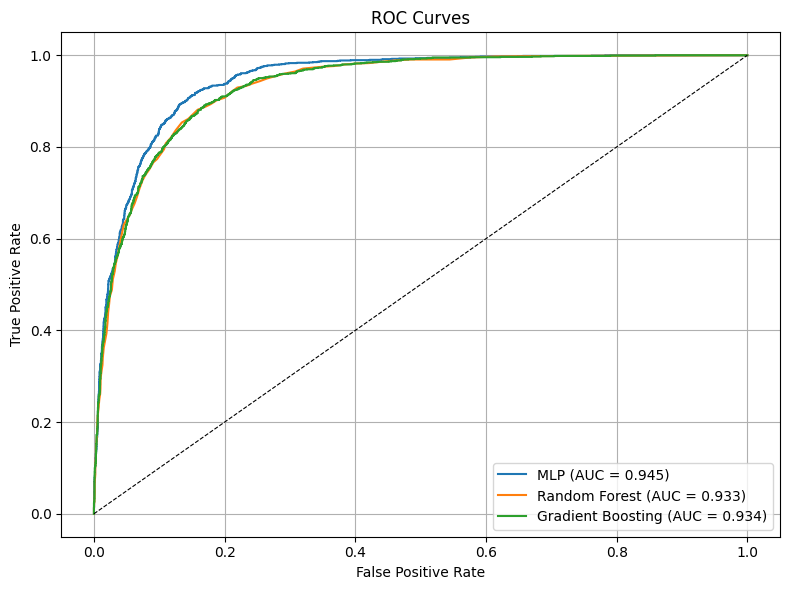

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import torch.nn.functional as F

# Asegurate de que y_val_np esté definido
# (ya lo tenés si ejecutaste los bloques anteriores)
# y que las etiquetas estén en formato binario (0/1)

# 1. MLP - predicción de probabilidades
mlp_torch.eval()
mlp_probs = []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        outputs = mlp_torch(xb)
        probs = F.softmax(outputs, dim=1)[:, 1]  # clase positiva
        mlp_probs.extend(probs.cpu().numpy())
mlp_probs = np.array(mlp_probs)
mlp_auc = roc_auc_score(y_val_np, mlp_probs)
fpr_mlp, tpr_mlp, _ = roc_curve(y_val_np, mlp_probs)

# 2. Random Forest
rf_probs = rf_model.predict_proba(X_val_np)[:, 1]
rf_auc = roc_auc_score(y_val_np, rf_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_val_np, rf_probs)

# 3. Gradient Boosting
gb_probs = gb_model.predict_proba(X_val_np)[:, 1]
gb_auc = roc_auc_score(y_val_np, gb_probs)
fpr_gb, tpr_gb, _ = roc_curve(y_val_np, gb_probs)

# 4. Plot all ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {mlp_auc:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.3f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/50, Loss: 84243077334.4427
Epoch 2/50, Loss: 2069146.0353
Epoch 3/50, Loss: 2066823.7923
Epoch 4/50, Loss: 2066746.1327
Epoch 5/50, Loss: 2066708.1070
Epoch 6/50, Loss: 2066657.7937
Epoch 7/50, Loss: 2066601.8387
Epoch 8/50, Loss: 2066597.1140
Epoch 9/50, Loss: 2066625.3953
Epoch 10/50, Loss: 2066647.2580
Epoch 11/50, Loss: 2066599.9140
Epoch 12/50, Loss: 2066592.7730
Epoch 13/50, Loss: 2066658.4387
Epoch 14/50, Loss: 2066793.5173
Epoch 15/50, Loss: 2066775.6090
Epoch 16/50, Loss: 2066757.6733
Epoch 17/50, Loss: 2066741.9607
Epoch 18/50, Loss: 2066732.9227
Epoch 19/50, Loss: 2066720.0330
Epoch 20/50, Loss: 2066700.3353
Epoch 21/50, Loss: 2066669.6540
Epoch 22/50, Loss: 2066634.9263
Epoch 23/50, Loss: 2066630.2613
Epoch 24/50, Loss: 2066628.3187
Epoch 25/50, Loss: 2066626.3160
Epoch 26/50, Loss: 2066624.2470
Epoch 27/50, Loss: 2066621.9803
Epoch 28/50, Loss: 2066619.5760
Epoch 29/50, Loss: 2066617.0993
Epoch 30/50, Loss: 2066614.4070
Epoch 31/50, Loss: 2066611.5567
Epoch 32/50, 

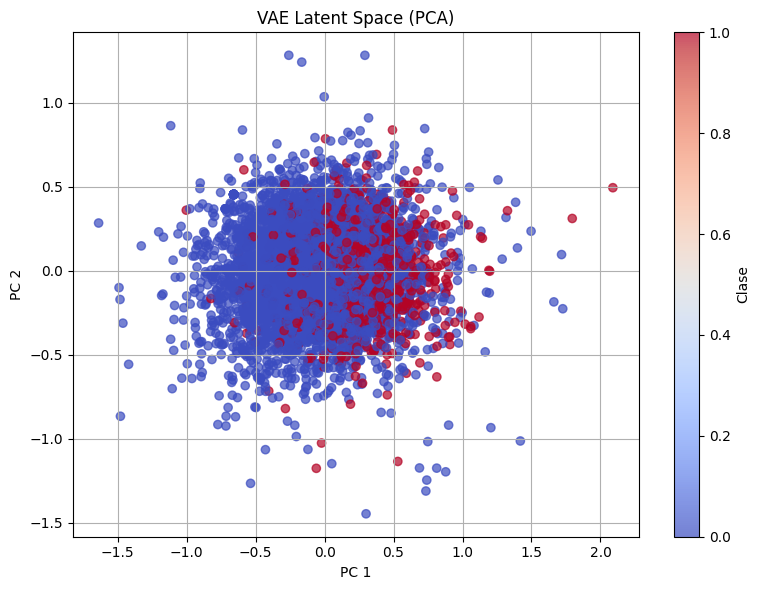

In [14]:
# --------------------------
# Definición del VAE
# --------------------------
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

def vae_loss(x, x_hat, mu, logvar):
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# --------------------------
# Entrenamiento
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(X_train.shape[1], latent_dim=10).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

epochs = 50
for epoch in range(epochs):
    vae.train()
    total_loss = 0
    for xb, _ in train_loader:
        xb = xb.to(device)
        x_hat, mu, logvar = vae(xb)
        loss = vae_loss(xb, x_hat, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# --------------------------
# Visualización con PCA
# --------------------------
vae.eval()
all_mu = []
all_labels = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        mu, _ = vae.encode(xb)
        all_mu.append(mu.cpu().numpy())
        all_labels.append(yb.numpy())

all_mu = np.concatenate(all_mu, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

pca = PCA(n_components=2)
z_pca = pca.fit_transform(all_mu)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=all_labels, cmap='coolwarm', alpha=0.7)
plt.title("VAE Latent Space (PCA)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(scatter, label="Clase")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(all_mu)

ari = adjusted_rand_score(all_labels, cluster_labels)
print(f"Adjusted Rand Index (KMeans): {ari:.4f}")




              precision    recall  f1-score   support

           0       0.82      0.94      0.87      4595
           1       0.60      0.30      0.40      1405

    accuracy                           0.79      6000
   macro avg       0.71      0.62      0.64      6000
weighted avg       0.77      0.79      0.76      6000

